In [1]:
%matplotlib inline
import twixtools
import numpy as np
import matplotlib.pyplot as plt
import os

example_dir = '../example_data'

def ifftnd(sig, axes=[-1]):
    out = sig.copy()
    for axis in axes:
        out = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(out, axes=[axis]), axis=axis), axes=[axis])
    return out


def fftnd(sig, axes=[-1]):
    out = sig.copy()
    for axis in axes:
        out = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(data, axes=[axis]), axis=axis), axes=[axis])
    return out

def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

In [3]:
twix_epi = twixtools.read_twix(os.path.join(example_dir, 'meas_MID00269_FID117232_ep2d_bold.dat'))
epi = twixtools.map_twix(twix_epi)

Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.
Scan  1
100 % parsed in 0 s. Estimated 0 s remaining.


['Seg', 'Cha', 'Col']


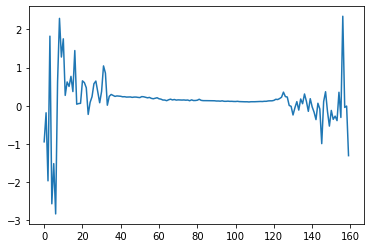

In [4]:
epi[1]['phasecorr'].flags['average']['Ave']=True
epi[1]['phasecorr'].flags['average']['Lin']=True
epi[1]['phasecorr'].flags['average']['Par']=True
print(epi[1]['phasecorr'].non_singleton_dims)
data = epi[1]['phasecorr'][:].squeeze()

plt.plot(np.angle(ifftnd(data[0,0,:]) * np.conj(ifftnd(data[1,0,:]))))

['Lin', 'Cha', 'Col']


(-0.5, 79.5, 79.5, -0.5)

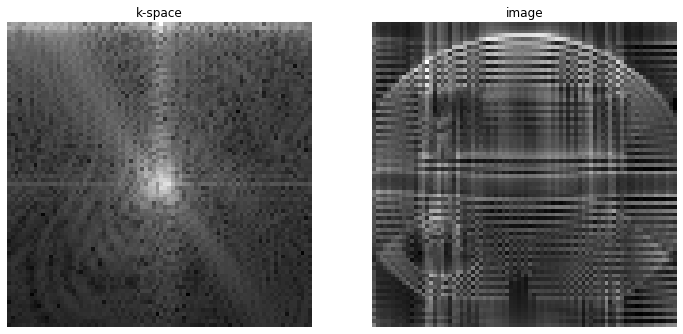

In [5]:
epi[1]['image'].flags['average']['Seg'] = True
epi[1]['image'].flags['remove_os'] = True
print(epi[1]['image'].non_singleton_dims)

data = epi[1]['image'][:].squeeze()


plt.figure(figsize=[12,8])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(data[:,0])**0.2, cmap='gray')
plt.axis('off')


image = ifftnd(data, [0,-1])
image = rms_comb(image)
plt.subplot(122)
plt.title('image')
plt.imshow(image, cmap='gray')
plt.axis('off')

Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.
Scan  1
100 % parsed in 0 s. Estimated 0 s remaining.
['Lin', 'Cha', 'Col']


(-0.5, 127.5, 127.5, -0.5)

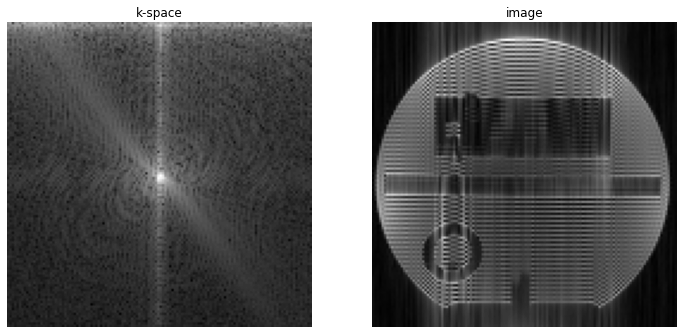

In [6]:
twix_multichan = twixtools.read_twix(os.path.join(example_dir, 'meas_MID00266_FID117229_gre.dat'))
multichan = twixtools.map_twix(twix_multichan)
print(multichan[-1]['image'].non_singleton_dims)
multichan[-1]['image'].flags['remove_os'] = True
data = multichan[-1]['image'][:].squeeze()

plt.figure(figsize=[12,8])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(data[:,0])**0.2, cmap='gray')
plt.axis('off')


image = ifftnd(data, [0,-1])
image = rms_comb(image)
plt.subplot(122)
plt.title('image')
plt.imshow(image, cmap='gray')
plt.axis('off')

Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.
['Rep', 'Lin', 'Cha', 'Col']


(-0.5, 127.5, 127.5, -0.5)

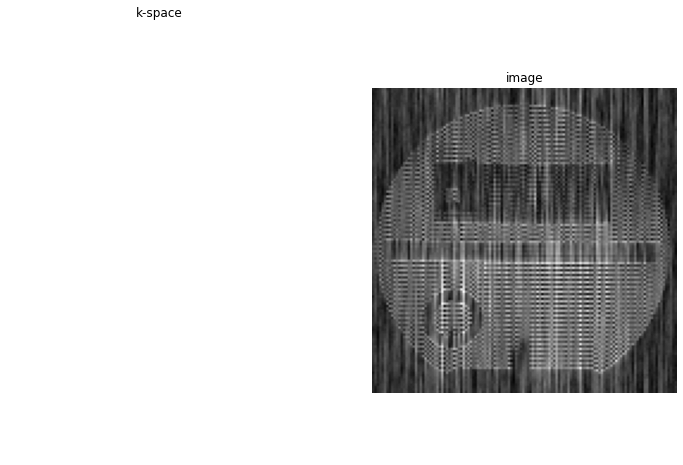

In [20]:
twix_singlechan = twixtools.read_twix(os.path.join(example_dir, 'meas_MID00273_FID117236_gre_bodycoil.dat'))
singlechan = twixtools.map_twix(twix_singlechan)
print(singlechan[-1]['image'].non_singleton_dims)
singlechan[-1]['image'].flags['remove_os'] = True
data = singlechan[-1]['image'][:].squeeze()[0]

plt.figure(figsize=[12,8])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(data[:,0])**0.2, cmap='gray')
plt.axis('off')


image = ifftnd(data, [0,-1])
image = rms_comb(image)
plt.subplot(122)
plt.title('image')
plt.imshow(abs(image), cmap='gray')
plt.axis('off')

In [18]:
print(len(singlechan[-1]['image'].mdb_list))
for mdb in singlechan[-1]['image'].mdb_list:
    print(mdb.cLin, mdb.cRep, mdb.get_active_flags())

256
0 0 ['ONLINE', 'FIRSTSCANINSLICE']
1 0 ['ONLINE']
2 0 ['ONLINE']
3 0 ['ONLINE']
4 0 ['ONLINE']
5 0 ['ONLINE']
6 0 ['ONLINE']
7 0 ['ONLINE']
8 0 ['ONLINE']
9 0 ['ONLINE']
10 0 ['ONLINE']
11 0 ['ONLINE']
12 0 ['ONLINE']
13 0 ['ONLINE']
14 0 ['ONLINE']
15 0 ['ONLINE']
16 0 ['ONLINE']
17 0 ['ONLINE']
18 0 ['ONLINE']
19 0 ['ONLINE']
20 0 ['ONLINE']
21 0 ['ONLINE']
22 0 ['ONLINE']
23 0 ['ONLINE']
24 0 ['ONLINE']
25 0 ['ONLINE']
26 0 ['ONLINE']
27 0 ['ONLINE']
28 0 ['ONLINE']
29 0 ['ONLINE']
30 0 ['ONLINE']
31 0 ['ONLINE']
32 0 ['ONLINE']
33 0 ['ONLINE']
34 0 ['ONLINE']
35 0 ['ONLINE']
36 0 ['ONLINE']
37 0 ['ONLINE']
38 0 ['ONLINE']
39 0 ['ONLINE']
40 0 ['ONLINE']
41 0 ['ONLINE']
42 0 ['ONLINE']
43 0 ['ONLINE']
44 0 ['ONLINE']
45 0 ['ONLINE']
46 0 ['ONLINE']
47 0 ['ONLINE']
48 0 ['ONLINE']
49 0 ['ONLINE']
50 0 ['ONLINE']
51 0 ['ONLINE']
52 0 ['ONLINE']
53 0 ['ONLINE']
54 0 ['ONLINE']
55 0 ['ONLINE']
56 0 ['ONLINE']
57 0 ['ONLINE']
58 0 ['ONLINE']
59 0 ['ONLINE']
60 0 ['ONLINE']
61 0 ['ONL